In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import nltk
import time
import csv
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sentence_transformers import SentenceTransformer

import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

e:\CS 421 - Project 1\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

def clean_text(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words]
    cleaned_text = " ".join(filtered_tokens)
    return cleaned_text

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tranx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tranx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tranx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
df_train = pd.read_csv("trac2_CONVT_train.csv")
convoColumn = df_train["text"]
emotionColumn = df_train["Emotion"]
emotionalPolarityColumn = df_train["EmotionalPolarity"]
emphathyColumn = df_train["Empathy"]
print(convoColumn)

0                    what did you think about this article
1        It's definitely really sad to read, considerin...
2        I think it's super sad... they seem to never c...
3        I can't imagine just living in an area that is...
4        Me too.. I also can't imagine living in the po...
                               ...                        
11085      Do you think maybe he was force to kill himself
11086                          I think somebody killed him
11087    Or he could have slipped on something. Either ...
11088    I don't know if he was nice or not. It was nic...
11089                                   ok thank you. bye!
Name: text, Length: 11090, dtype: object


In [8]:
from numpy import unique
emotionColumnIndex = df_train.columns.get_loc("Emotion")
emotionPolarityColumnIndex = df_train.columns.get_loc("EmotionalPolarity")
emphathyColumnIndex = df_train.columns.get_loc("Empathy")

Y_train_reg = []
Y_train_class = []
instance = []
for i in range(0, len(df_train)):
    instance.append(df_train.iloc[i, emotionColumnIndex])

    instance.append(df_train.iloc[i, emphathyColumnIndex])
    Y_train_reg.append(instance)
    instance = []

for i in range(0, len(df_train)):

    instance.append(df_train.iloc[i, emotionPolarityColumnIndex])

    Y_train_class.append(instance)
    instance = []

Y_train_reg = np.array(Y_train_reg)
Y_train_class = np.array(Y_train_class)
nClass = len(unique(Y_train_class))
print(nClass)
print(Y_train_reg)
print(Y_train_class)

4
[[1 1]
 [3 4]
 [4 5]
 ...
 [3 4]
 [2 1]
 [2 1]]
[[1]
 [2]
 [2]
 ...
 [2]
 [0]
 [0]]


In [7]:
model = SentenceTransformer('all-MiniLM-L6-v2')

X_train = model.encode(convoColumn, device = device)

X_train

array([[-0.04389283,  0.10513641,  0.02143801, ...,  0.02334088,
         0.0357709 ,  0.02619347],
       [ 0.00312208, -0.01316165,  0.04050577, ..., -0.0167838 ,
        -0.02064485,  0.02052207],
       [ 0.02436971, -0.05185754,  0.07622936, ...,  0.00298887,
         0.01370774,  0.08541711],
       ...,
       [-0.04096856,  0.10766791,  0.00549288, ..., -0.07089469,
        -0.06134705,  0.00029319],
       [-0.03980826,  0.05686442,  0.01994038, ...,  0.04827635,
        -0.12452774, -0.02795004],
       [-0.03743479, -0.05327813,  0.05168473, ..., -0.02701607,
        -0.01122839,  0.04988116]], shape=(11090, 384), dtype=float32)

In [9]:
seed_value = 42 # You can choose any integer value

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

tf.random.set_seed(seed_value)
inputs= Input(shape = (384,))

x1Regression = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
BatchNormalization()(x1Regression)
Dropout(0.2)(x1Regression)

x2Regression = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x1Regression)
BatchNormalization()(x2Regression)
Dropout(0.2)(x2Regression)

regression_output = Dense(2, name='regression')(x2Regression)

x1Classfication = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
BatchNormalization()(x1Classfication),
Dropout(0.2)

x2Classification = Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x1Classfication)
BatchNormalization()(x2Classification),
Dropout(0.2)

classification_output = Dense(nClass, activation = 'softmax', name='classification')(x2Classification)

modelNLP = Model(inputs = inputs, outputs=[regression_output, classification_output])

modelNLP.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'regression': 'mse',
        'classification': 'categorical_crossentropy'
    },
    metrics={
        'regression': ['mse'],
        'classification': ['accuracy']
    }
)

plot_model(modelNLP, to_file='model.png', show_shapes=True)

modelNLP.fit(
    X_train, [Y_train_reg, to_categorical(Y_train_class, num_classes = nClass)],
    epochs=50,
    batch_size=32,
    validation_split=0.2
)


You must install pydot (`pip install pydot`) for `plot_model` to work.
Epoch 1/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - classification_accuracy: 0.5920 - classification_loss: 0.8779 - loss: 2.1290 - regression_loss: 1.0077 - regression_mse: 1.0090 - val_classification_accuracy: 0.6655 - val_classification_loss: 0.7252 - val_loss: 1.5540 - val_regression_loss: 0.6329 - val_regression_mse: 0.6365
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - classification_accuracy: 0.6691 - classification_loss: 0.7101 - loss: 1.3775 - regression_loss: 0.5005 - regression_mse: 0.5005 - val_classification_accuracy: 0.6519 - val_classification_loss: 0.7193 - val_loss: 1.4623 - val_regression_loss: 0.5926 - val_regression_mse: 0.5962
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - classification_accuracy: 0.6758 - classification_loss: 0.6929 - loss: 1.3024 - regression_loss: 0.4748 - regression_mse: 0.4748 - val_classification_accuracy: 0.6537 - val_classification_loss: 0.7184 - val_loss:

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
df_test = pd.read_csv("trac2_CONVT_dev.csv")
df_test["EmotionalPolarity"] = np.ceil(df_test['EmotionalPolarity'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
convoColumnTest = df_test["text"]


X_test = model.encode(convoColumnTest, device = device)


emotionColumnIndex = df_test.columns.get_loc("Emotion")
emotionPolarityColumnIndex = df_test.columns.get_loc("EmotionalPolarity")
emphathyColumnIndex = df_test.columns.get_loc("Empathy")

Y_test_reg = []
Y_test_class = []
instance = []
for i in range(0, len(df_test)):
    instance.append(df_test.iloc[i, emotionColumnIndex])

    instance.append(df_test.iloc[i, emphathyColumnIndex])
    Y_test_reg.append(instance)
    instance = []

for i in range(0, len(df_test)):
    instance.append(df_test.iloc[i, emotionPolarityColumnIndex])
    Y_test_class.append(instance)
    instance = []

Y_test_reg = np.array(Y_test_reg)
Y_test_class = np.array(Y_test_class)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[array([[0.99181974, 0.6213963 ],
       [1.4279419 , 0.8121117 ],
       [1.4968605 , 0.86272514],
       ...,
       [3.1811972 , 2.9463387 ],
       [2.1343303 , 2.0746694 ],
       [2.3790586 , 2.391355  ]], shape=(990, 2), dtype=float32), array([[1.70747545e-02, 9.82904017e-01, 2.06672939e-05, 5.93319157e-07],
       [2.99015850e-01, 7.00875103e-01, 1.08145294e-04, 9.44312035e-07],
       [9.64022219e-01, 3.59507091e-02, 2.69592583e-05, 2.23024532e-08],
       ...,
       [1.79965682e-02, 7.12312683e-02, 9.10659850e-01, 1.12224028e-04],
       [1.72209531e-01, 8.18919122e-01, 8.84253811e-03, 2.87958464e-05],
       [8.63194406e-01, 6.46289736e-02, 7.21595064e-02, 1.70892035e-05]],
      shape=(990, 4), dtype=float32)]
MSE per output: [0.45103766 0.92846497]
RMSE per output: [0.67159337 0.96356887]
MAE per output: [0.52754451 0.79253618]
R2 per output: [0.19096458 0.22941772]
[[ 66  72  19]
 [ 42 293 114]
 [ 13 115 256]]


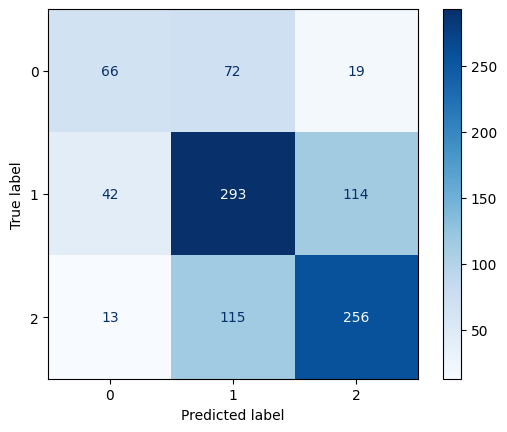

0.6186090490281014 0.6212121212121212 0.6182966633019346 0.6212121212121212


In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = modelNLP.predict(X_test)
print(y_pred)

y_class_pred = np.argmax(y_pred[1], axis=1)


mse = mean_squared_error(Y_test_reg, y_pred[0], multioutput='raw_values')
print("MSE per output:", mse)

rmse = np.sqrt(mse)
print("RMSE per output:", rmse)

mae = mean_absolute_error(Y_test_reg, y_pred[0], multioutput='raw_values')
print("MAE per output:", mae)

r2 = r2_score(Y_test_reg, y_pred[0], multioutput='raw_values')
print("R2 per output:", r2)

cm = confusion_matrix(Y_test_class, y_class_pred)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

precision = precision_score(Y_test_class, y_class_pred, average = "weighted")

recall = recall_score(Y_test_class, y_class_pred, average = "weighted")

f1 = f1_score(Y_test_class, y_class_pred, average = "weighted")

accuracy = accuracy_score(Y_test_class, y_class_pred)

print(precision, recall, f1, accuracy)
